# Exocomet free spectrum

In this workbook we want to create an "exocomet free" spectrum. Wish such a spectrum we can remove constant spectral features and thus be left with only the signatures of the exocomets.

### Load the data

In [1]:
import numpy as np
import json, sys, os

import matplotlib.pyplot as plt
from matplotlib import rc, cm

# get the path of the current directory
path = os.getcwd()
home = os.path.dirname(path)

# Print the repository home directory
print("Repository home directory:",home)

# Add the src folder to the system path
sys.path.append(home+'/src')

# Import the python functions from src
from calculations import Calc, Model, Stats

# We shorten the functions name to make it easier to call the required a functions
c   = Calc()
m   = Model()
s   = Stats()

# Importing parameters from a json file.
with open(home+'/params.json') as param_file:    
   param = json.load(param_file)

# We read in the data directories we are using. To see what directories this is open params.json.
datadirs = param["datadirs"]

# We select part A which is the red end of the spectrum (the other part being B, which is the blue end)
part     = param["BetaPictoris"]["part"]

Repository home directory: /home/pas/science/exocomets


In [2]:
# The structure here is
# DP[visit][orbit][0 = wavelength, 1 = flux, 2 = one sigma uncertainty, 3 = datetime]

if param["filenames"]["split_files"] == "yes":
    DP   = c.LoadData(home+'/data/Dnsn_'+part+'_split.npz')
else:
    DP   = c.LoadData(home+'/data/Dnsn_'+part+'.npz')

### Create a master spectrum
We do a weighted average of the spectra.

In [3]:
import numpy as np

spec        = []
spec_err    = []

for i in range(len(DP)):          # Cycle over number of visits
    for j in range(len(DP[i])):   # Cycle over number of fits files each visit
        spec.append(DP[i][j][1])
        spec_err.append(DP[i][j][2])

spec        = np.array(spec)
spec_err    = np.array(spec_err)

print("Combining",str(len(spec))," spectra")

spec        = c.ReplaceWithSmallNumber(spec)
spec_err    = c.ReplaceWithOne(spec_err)

weights     = 1./(spec_err**2)
weights     = weights/np.sum(weights)   # Technically not needed as np.average does this

spec_w_ave  = np.average(spec, axis=0, weights=weights)
errorbars_2 = np.sum((weights*spec_err)**2, axis=0)

np.savez(home+'/data/spec_'+part+'.npz', spec, dtype=object)
np.savez(home+'/data/master_spec_'+part+'.npz', spec_w_ave, dtype=object)

Combining 83  spectra


### Just to make sure you use all the data

In [4]:
if len(datadirs) < 13:
    print("\n"*15,"Don't forget to create the exocomet free spectrum using all the data!","\n"*15)
    sys.exit()

if len(spec) < 83 and param["filenames"]["split_files"] == "yes":
    print("Using",len(DP[0]),"spectra")
    print("\n"*15,"You need to run load_the_data again using all the data!","\n"*15)
    sys.exit()

### Create an exocomet free spectrum
We create an average of the top n% of spectra with the highest flux. The induced offset is then subtracted of. The offset is calculated as the difference between the average of the top n% spectra and the average value for the weighted average of all spectra (both over a given region). 

In [5]:
# We adopt the wavlenth array from the first visit with split sum files.
# When working with non-split data we use the wavelenth range from the 2014 visit
# (any other date would do as all the spectra are aligned)
w = DP[0][0][0]

# Select the region which we can use to calculate the the standard devication of.
s1, s2 = c.RegionSelect(w, 1396, 1401)

# Create an exocomet free spectrum by taking the median of the top 20% of spectra
cut_off = 0.10

# Calculate how many spectra are used to create the exocomet free spectrum
top = round(len(spec)*cut_off)

print("Combining top",top,"spectra")

# Sort the spectra
spec_sort = np.sort(spec,axis=0)

# Take an average of a selection of spectra with the highest flux values
spec_top_ave = np.average(spec_sort[-top:],axis=0)

# Calculate the offset between the average of the top spectra and the average of the weighted average of ALL spectra.
ave_flux_diff = np.average(spec_top_ave[s1:s2]-np.average(spec_w_ave[s1:s2]))

# Exocomet Free Spectrum (we subtract off the bias form selecting the top n% spectra.)
ecf = spec_top_ave-ave_flux_diff

# Calculate the standard deviation (used to calculate uncertainties)
ecf_std = np.std(ecf[s1:s2])

# Create an array of uncertainties (they are all the same size, this needs adjusting later when
# I have more time. We should be using the error on the data points.)
ecf_err = np.ones(len(ecf))*ecf_std

# This is how we did it previously. I have kept it here for comparison.
threshold = np.percentile(spec, 85, axis=0)
ecf_old = threshold-np.average(np.std(spec, axis=0)[s1:s2])

np.savez(home+'/data/ECF_'+part+'.npz', ecf, dtype=object)
np.savez(home+'/data/ECF_'+part+'_err.npz', ecf_err, dtype=object)

Combining top 8 spectra


In [6]:
# Setting the parameters for the plots
plotting_params = {'backend': 'wxAgg',
                   'font.family': 'serif',
                   'font.size': 22,
                   'lines.markersize' : 2,
                   'axes.labelsize': 22,
                   'legend.fontsize': 22,
                   'xtick.labelsize': 22,
                   'ytick.labelsize': 22,
                   'text.usetex': True}

plt.rcParams.update(plotting_params)

Text(0, 0.5, 'Flux [erg/s/cm$^2$/\\AA]')

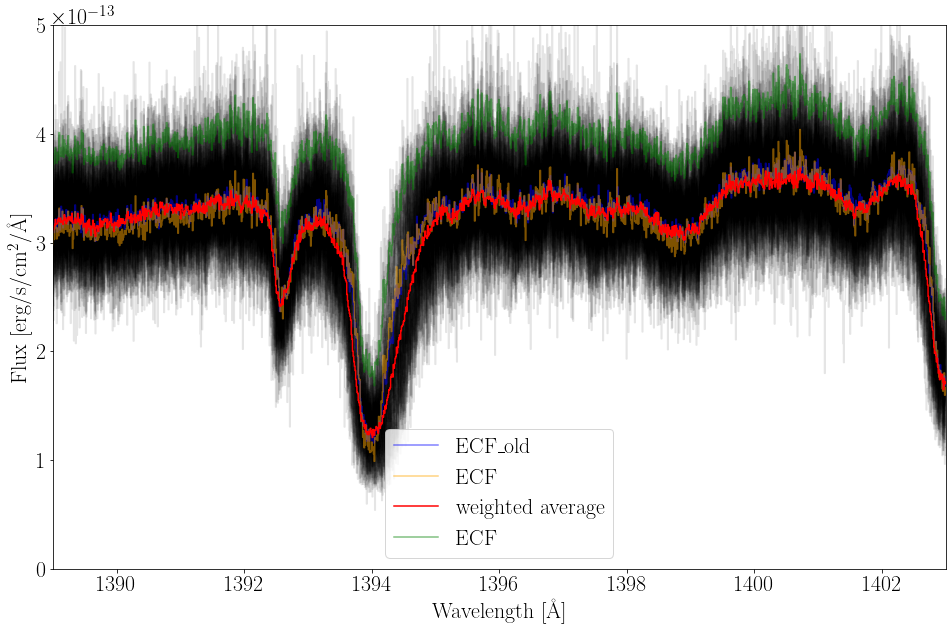

In [7]:
#%matplotlib widget
fig = plt.figure(figsize=(16.0,10.0))

for i in range(len(DP)):
    for j in range(len(DP[i])):
        plt.step(DP[i][j][0],DP[i][j][1],c="black",alpha=0.1)
plt.step(DP[0][0][0],ecf_old,c="blue",alpha=0.5,label="ECF_old")
plt.step(DP[0][0][0],ecf,c="orange",alpha=0.5,label="ECF")
plt.step(DP[0][0][0],spec_w_ave,c="red",label="weighted average")
plt.step(DP[0][0][0],spec_top_ave,c="green",alpha=0.5,label="ECF")

plt.legend(loc='lower center', numpoints=1)
plt.xlim(1389,1403)
plt.ylim(0,5e-13)

plt.xlabel(r'Wavelength [\AA]')
plt.ylabel(r'Flux [erg/s/cm$^2$/\AA]')

The dips in the line center show that the line is saturated.

Text(0.5, 0, 'Wavelength [\\AA]')

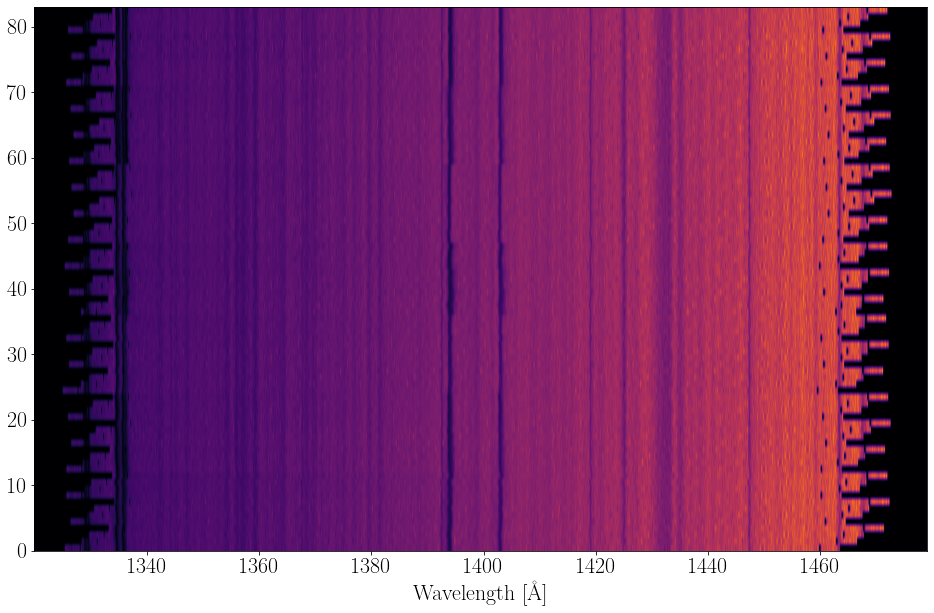

In [8]:
# We plot the entire dataset with the earlier spectra shown at the top of the plot.

s1, s2 = c.RegionSelect(w, 1320, 1479)

wave = w[s1:s2]
spec_range   = len(wave)

spec_c = []
for i in range(len(spec)):
    spec_c.append(spec[i][s1:s2])

spec_c = np.array(spec_c)

rows         = len(spec_c)

S            = spec_c.reshape(rows,spec_range)
cmap = plt.get_cmap('inferno')

fig = plt.figure(figsize=(16.0,10.0))
plt.imshow(S,cmap=cmap,extent=[wave[0],wave[-1],0,len(S)],aspect='auto')
plt.xlabel(r'Wavelength [\AA]')
#plt.xlim(1392, 1407)

### We subtract off the exocomet free spectrum

In [9]:
y_ticks = []
y_labels = []
counter = 97
spec_exocomet = []
for i in range(len(DP)):
    for j in range(len(DP[i])):
        print("█▓▒▒░░░ Visit:",i+1,"-","orbit:",str(j+1)+"/"+str(len(DP[i])),"░░░▒▒▓█")
        spec_exocomet.append(DP[i][j][1][s1:s2]-ecf[s1:s2])
        
        if j == len(DP[i])-1:
            counter = counter - len(DP[i])-1.0
            y_labels.append(DP[i][j][3].strftime("%d %b %Y"))
            y_ticks.append(counter)
            spec_exocomet.append(np.ones(spec_range)*-1)
            print("")

spec_exocomet = np.array(spec_exocomet)

█▓▒▒░░░ Visit: 1 - orbit: 1/12 ░░░▒▒▓█
█▓▒▒░░░ Visit: 1 - orbit: 2/12 ░░░▒▒▓█
█▓▒▒░░░ Visit: 1 - orbit: 3/12 ░░░▒▒▓█
█▓▒▒░░░ Visit: 1 - orbit: 4/12 ░░░▒▒▓█
█▓▒▒░░░ Visit: 1 - orbit: 5/12 ░░░▒▒▓█
█▓▒▒░░░ Visit: 1 - orbit: 6/12 ░░░▒▒▓█
█▓▒▒░░░ Visit: 1 - orbit: 7/12 ░░░▒▒▓█
█▓▒▒░░░ Visit: 1 - orbit: 8/12 ░░░▒▒▓█
█▓▒▒░░░ Visit: 1 - orbit: 9/12 ░░░▒▒▓█
█▓▒▒░░░ Visit: 1 - orbit: 10/12 ░░░▒▒▓█
█▓▒▒░░░ Visit: 1 - orbit: 11/12 ░░░▒▒▓█
█▓▒▒░░░ Visit: 1 - orbit: 12/12 ░░░▒▒▓█

█▓▒▒░░░ Visit: 2 - orbit: 1/12 ░░░▒▒▓█
█▓▒▒░░░ Visit: 2 - orbit: 2/12 ░░░▒▒▓█
█▓▒▒░░░ Visit: 2 - orbit: 3/12 ░░░▒▒▓█
█▓▒▒░░░ Visit: 2 - orbit: 4/12 ░░░▒▒▓█
█▓▒▒░░░ Visit: 2 - orbit: 5/12 ░░░▒▒▓█
█▓▒▒░░░ Visit: 2 - orbit: 6/12 ░░░▒▒▓█
█▓▒▒░░░ Visit: 2 - orbit: 7/12 ░░░▒▒▓█
█▓▒▒░░░ Visit: 2 - orbit: 8/12 ░░░▒▒▓█
█▓▒▒░░░ Visit: 2 - orbit: 9/12 ░░░▒▒▓█
█▓▒▒░░░ Visit: 2 - orbit: 10/12 ░░░▒▒▓█
█▓▒▒░░░ Visit: 2 - orbit: 11/12 ░░░▒▒▓█
█▓▒▒░░░ Visit: 2 - orbit: 12/12 ░░░▒▒▓█

█▓▒▒░░░ Visit: 3 - orbit: 1/12 ░░░▒▒▓█
█▓▒▒░░░ Visit: 3 

### We produce the exocomet plot (all constant spectral lines have been subtracted out)

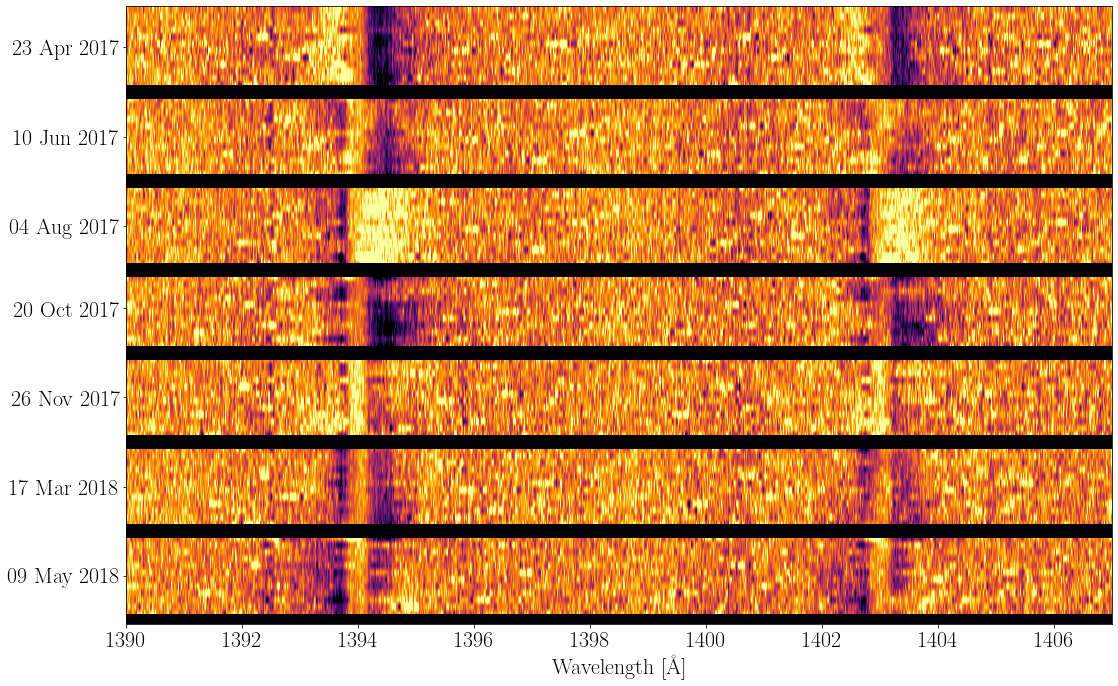

In [16]:
rows         = len(spec_exocomet)
EXO          = spec_exocomet.reshape(rows,spec_range)

fig = plt.figure(figsize=(16.0,10.0))
plt.imshow(EXO,cmap=cmap,extent=[wave[0],wave[-1],0,len(EXO)],vmin=-1.2e-13,vmax=5e-14,aspect='auto')
plt.xlim(1390,1407)
plt.gca().set_yticks(y_ticks) 
plt.gca().set_yticklabels(y_labels)
plt.xlabel(r'Wavelength [Å]')
fig.tight_layout()
plt.savefig(home+'/plots/presentation/exocomets.jpg',dpi=150)